# Imports

In [78]:
import datetime
import speech_recognition as sr
import pyaudio
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import spacy
from textblob import TextBlob
import en_core_web_sm
import pyttsx3
from nltk import chunk
from nltk.tag import DefaultTagger
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import metrics
from scipy.spatial import distance

# Reading Data and Data Preprocessing

In [158]:
df = pd.read_csv("product_reviews_labelled_dataset2.csv")
df_ner = df.copy()
df=df[df["Sentiments"]!="neutral"].copy()
le = LabelEncoder()
df["labels"] = le.fit_transform(df["Sentiments"])
item_list = set(df["Name"])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def preprocess(all_reviews):
    reviews = []
    for i in all_reviews:
        letters_only = re.sub("[^a-zA-Z]", " ", i)
        words = letters_only.lower().split()
        stops = set(stopwords.words('english'))
        removed_s_words = [w for w in words if not w in stops]
        doc = nlp(" ".join(removed_s_words))
        text = " ".join([word.lemma_ if word.lemma_ != "-PRON-" else word.text for word in doc ])
        reviews.append(text)
    return reviews
df["Reviews"] = preprocess(df["Reviews"])
df.drop(df.columns[0], axis = 1, inplace=True)
df_ner["Reviews"] = preprocess(df_ner["Reviews"])
df_ner.drop(df_ner.columns[0], axis = 1, inplace=True)
print(df["Reviews"])

0                                            value money
1                                 superb picture quality
2      deep detail tv photo upload share whole hardwa...
3      first thank flipkart second one hisense review...
4      give review two day use happy product flipkart...
                             ...                        
813                              good product much noise
814                                                 okay
815                                         nice product
816                                         good quality
817            good product powerful clean happy product
Name: Reviews, Length: 802, dtype: object


# Exploratory Data Analysis

In [8]:
df['temp_list'] = df["Reviews"].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common Words','count']
temp.style.background_gradient(cmap='Greens')

,Common Words,count
0,good,889
1,quality,468
2,product,456
3,sound,382
4,tv,265
5,use,217
6,price,194
7,bass,186
8,nice,179
9,also,177


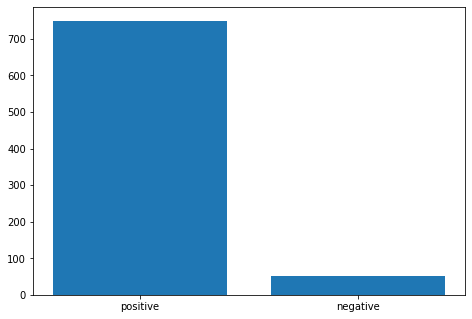

In [137]:
print()
x = list(df["Sentiments"].unique())
y = list(df["Sentiments"].value_counts())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()

# Training Amazon Reviews data using Decision Tree and testing it on flipkart data

In [16]:
data = pd.read_csv('Amazon_Unlocked_Mobile.csv')
data['Sentiment'] = np.where(data['Rating'] > 3, 1, 0)
data=data.sample(frac=0.09,random_state=10)

data = data[["Reviews","Sentiment"]]
data = data.dropna()
print(data)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

                                                  Reviews  Sentiment
394349  Very good one! Better than Samsung S and iphon...          1
34377   The phone needed a SIM card, would have been n...          0
248521  I was 3 months away from my upgrade and my Str...          1
167661                     an experience i want to forget          0
73287         GREAT PHONE WORK ACCORDING MY EXPECTATIONS.          1
...                                                   ...        ...
92271   Todo el proceso fue un exito cumplieron al pie...          1
139487  Although I received this item in good shape, a...          0
16575                                    It is acceptable          0
336446  I purchased this for my wife for our anniversa...          1
312945  Really nice phone. Better than expected. Came ...          1

[37237 rows x 2 columns]


In [21]:
data["Reviews"] = preprocess(data["Reviews"])

37237


In [98]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english',ngram_range=(1,2)).fit(data["Reviews"])

# bag-of-words feature matrix
bow = bow_vectorizer.transform(data['Reviews'])

df_bow = pd.DataFrame(bow.todense())
print(df_bow)

       0    1    2    3    4    5    6    7    8    9    ...  990  991  992  \
0        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
37232    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
37233    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
37234    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
37235    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
37236    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       993  994  995  996  997  998  999  
0       

In [170]:
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english').fit(data["Reviews"])

tfidf_matrix=tfidf.transform(data['Reviews'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

print(df_tfidf)

       0    1    2    3    4    5    6    7    8    9    ...  990  991  992  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
37232  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
37233  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
37234  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
37235  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
37236  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       993  994  995  996  997  998  999  
0      0

In [171]:
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(bow,data['Sentiment'],test_size=0.3,random_state=2)
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(tfidf_matrix,data['Sentiment'],test_size=0.3,random_state=17)

In [172]:
dtc = DecisionTreeClassifier(criterion='entropy', random_state=1)
dtc.fit(x_train_bow,y_train_bow)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

# Getting input data through speech and calculating top 3 products


In [148]:
engine = pyttsx3.init() 
#engine.setProperty("rate", 178)
voices = engine.getProperty('voices')
engine.setProperty('voices ', voices[0].id)


def speak(audio):
    engine.say(audio)
    engine.runAndWait()


def wishme():
    intro = "!I am Bugsbunny"#!Your Personal Assistant!Items available in our datasets are Tv, earphones, vacuum cleaner," \
            #"Please tell me which one do you want to select?"
    hour = int(datetime.datetime.now().hour)
    if (hour >= 0 and hour < 12):
        speak("Good Morning Group 17!" + intro)
    elif (hour >= 12 and hour < 18):
        speak("Good Afternoon Group 17" + intro)
    else:
        speak("Good Evening Group 17" + intro)

flag = True
def inputSpeech():

    r = sr.Recognizer()
    try:
        with sr.Microphone() as source:
            print("Listening...")

            r.adjust_for_ambient_noise(source)
            r.pause_threshold = 1
            r.energy_threshold
        while(flag):
            with sr.Microphone() as source:
                audio = r.listen(source)
                print("Recognizing...")
            try:
                query = r.recognize_google(audio)
                query = query.lower()

                if query not in item_list:
                    print(u"You said {} : Not found in the dataset".format(query))
                else:
                    return query

                # print("You said: ",response)
            except sr.UnknownValueError:
                print("Say that again please...")
                # return "None"
    except KeyboardInterrupt:
        pass

##############################
wishme()
input_product = inputSpeech()
print("Recognized: " + input_product)

Listening...
Recognizing...
You said laptop : Not found in the dataset
Recognizing...
You said card reader : Not found in the dataset
Recognizing...
Say that again please...
Recognizing...
Recognized: vacuum cleaner


In [159]:
df_item = df[df['Name']==input_product] #Taking dataframe of only input items
dict_prod = {}
item_unique = df_item["Products"].unique()

for i in item_unique: 
    prod = df[df["Products"]==i]
    review = list(prod["Reviews"])
    dict_prod[i] = review #Dictionary with every products as key and all reviews associated with that product as values in list

dict_polar = {}
for j in dict_prod:
    len_item = 0
    total_polar = 0
    
    for k in dict_prod[j]:
        blob = TextBlob(k)
        polar = blob.sentiment.polarity
        total_polar = total_polar + polar
        len_item = len_item + 1
    
    avg_polar = total_polar/len_item
    dict_polar[avg_polar] = j #Dictionary with average polarity of all reviews of each item as keys and the item itself as value  

all_keys = []
for key in dict_polar.keys():
    all_keys.append(key)
    
all_keys.sort(reverse=True) #Sorted values of average polarity of all items in decreasing order
print("Top 3 " + input_product + " products based on sentiments of it's reviews are:")

ner_prods = []
sentiments = df["Sentiments"].unique()
nlp = spacy.load("en_core_web_sm")
for i in range(3):
    print(dict_polar[all_keys[i]]+ ": "+ str(all_keys[i]))
    ner_prods.append(dict_polar[all_keys[i]])
print("\n")
for i,j in enumerate(ner_prods):
    print(str(i+1)+") " + j)
    tags = ["NN", "NNP", "JJ"]
    df2 = df_ner[df_ner["Products"]==j]
    for k in sentiments:
        ners = []
        df3 = df2[df2["Sentiments"]==k]
        ner_reviews = list(df3["Reviews"])
        rev = " ".join([i for i in ner_reviews])
        for token in nlp(rev):
            if token.tag_ in tags:
                if token.text not in ners:
                    if(len(ners)<30):
                        ners.append(token.text)
        print("* Entities recognized for "+k+" sentiments: "+ str(ners) +"\n")

     
    

Top 3 vacuum cleaner products based on sentiments of it's reviews are:
Probus W11 High Power Suction 600W Multi Use Portable Home Vacuum Cleaner with 5M Power Cord Hand-held...: 0.5473333333333333
Easymart JK Hand-held Vacuum Cleaner: 0.533068783068783
Kent KSL-612 Wet & Dry Vacuum Cleaner: 0.511059670781893


1) Probus W11 High Power Suction 600W Multi Use Portable Home Vacuum Cleaner with 5M Power Cord Hand-held...
* Entities recognized for positive sentiments: ['compact', 'powerful', 'job', 'order', 'parent', 'home', 'comfortable', 'sound', 'power', 'experience', 'nice', 'product', 'performance', 'value', 'money', 'delivery', 'doubt', 'excellent', 'awesome', 'high', 'quality', 'plastic', 'attachment', 'good', 'boy', 'useful', 'love', 'type', 'hair', 'dust']

* Entities recognized for negative sentiments: []

2) Easymart JK Hand-held Vacuum Cleaner
* Entities recognized for positive sentiments: ['good', 'product', 'useful', 'low', 'price', 'nice', 'suction', 'blower', 'single', 'unit

In [160]:
print("Bottom 3 " + input_product + " products based on sentiments of it's reviews are:")

ner_prods = []
sentiments = df["Sentiments"].unique()
#nlp = spacy.load("en_core_web_sm")
for i in range(-1,-4,-1):
    print(dict_polar[all_keys[i]]+ ": "+ str(all_keys[i]))
    ner_prods.append(dict_polar[all_keys[i]])
print("\n")
for i,j in enumerate(ner_prods):
    print(str(i+1)+") " + j)
    tags = ["NN", "NNP", "JJ"]
    df2 = df_ner[df_ner["Products"]==j]
    for k in sentiments:
        ners = []
        df3 = df2[df2["Sentiments"]==k]
        ner_reviews = list(df3["Reviews"])
        rev = " ".join([i for i in ner_reviews])
        for token in nlp(rev):
            if token.tag_ in tags:
                if token.text not in ners:
                    if(len(ners)<30):
                        ners.append(token.text)
        print("* Entities recognized for "+k+" sentiments: "+ str(ners) +"\n")


Bottom 3 vacuum cleaner products based on sentiments of it's reviews are:
Panasonic MC-DL201B14B Hand-held Vacuum Cleaner: 0.17464642203035066
Karcher vc4 battery (white)*KAP Cordless Vacuum Cleaner: 0.24491819291819295
Eureka Forbes Sure Active Clean Hand-held Vacuum Cleaner: 0.26097267316017314


1) Panasonic MC-DL201B14B Hand-held Vacuum Cleaner
* Entities recognized for positive sentiments: ['vacuum', 'cleaner', 'bhk', 'clean', 'particular', 'model', 'capable', 'cleaning', 'spec', 'small', 'box', 'wrong', 'product', 'design', 'packaging', 'nozzles', 'extension', 'wand', 'switch', 'noise', 'bearable', 'compare', 'good', 'intend', 'prolong', 'usage', 'heat', 'hr', 'time', 'width']

* Entities recognized for negative sentiments: []

2) Karcher vc4 battery (white)*KAP Cordless Vacuum Cleaner
* Entities recognized for positive sentiments: ['heavy', 'side', 'good', 'machine', 'suction', 'power', 'dosent', 'heat', 'charge', 'last', 'round', 'full', 'home', 'sweep', 'come', 'mode', 'versio

In [173]:
dtc_bow = dtc.predict_proba(x_valid_bow)
print(dtc_bow.shape)
dtc_bow=dtc_bow[:,1]>=0.3
dtc_int_bow=dtc_bow.astype(np.int)
dtc_score_bow=f1_score(y_valid_bow,dtc_int_bow)
print("Score of Decision Tree using Count Vectorizer as feature: "+str(dtc_score_bow))

(11172, 2)
Score of Decision Tree using Count Vectorizer as feature: 0.8774834437086092


In [174]:
dtc.fit(x_train_tfidf,y_train_tfidf)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [175]:
dtc_tfidf = dtc.predict_proba(x_valid_tfidf)

dtc_tfidf=dtc_tfidf[:,1]>=0.3

dtc_int_tfidf=dtc_tfidf.astype(np.int)

dtc_score_tfidf=f1_score(y_valid_tfidf,dtc_int_tfidf)

print("Score of Decision Tree using Tfidf Vectorizer as feature: "+str(dtc_score_tfidf))

Score of Decision Tree using Tfidf Vectorizer as feature: 0.8823303947872747


# Testing the model on scraped flipkart data

In [178]:
bow_flipk = bow_vectorizer.fit_transform(df['Reviews'])
dtc_bow = dtc.predict_proba(bow_flipk)
dtc_bow=dtc_bow[:,1]>=0.3
dtc_int_bow=dtc_bow.astype(np.int)
dtc_score_flipk_bow=f1_score(df["labels"],dtc_int_bow)
print("F1 Score of Decision Tree using Count Vectorizer as feature: "+str(dtc_score_flipk_bow))

F1 Score of Decision Tree using Count Vectorizer as feature: 0.5487228003784295


In [179]:
tfidf_flipk = tfidf.fit_transform(df['Reviews'])
dtc_tfidf = dtc.predict_proba(tfidf_flipk)

dtc_tfidf=dtc_tfidf[:,1]>=0.3

dtc_int_tfidf=dtc_tfidf.astype(np.int)

dtc_score_flipk_tfidf=f1_score(df["labels"],dtc_int_tfidf)

print("F1 Score of Decision Tree using Tf-idf Vectorizer as feature: "+str(dtc_score_flipk_tfidf))

F1 Score of Decision Tree using Tf-idf Vectorizer as feature: 0.701255230125523
